# MovieLens 100K Recommender System - Phase 1
## Data Loading, EDA, and Baseline Models

**Project:** Hybrid Movie Recommendation System  
**Dataset:** MovieLens 100K  
**Author:** Harpinder Singh  
**Date:** December 2025  

## ╔═══════════════════════════════════════════════════════════╗
## ║                    IMPORTS & SETUP                        ║
## ╚═══════════════════════════════════════════════════════════╝

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import zipfile
import os
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")
print(f"📅 Execution Date: {datetime.now().strftime('%B %d, %Y')}")

✅ Libraries imported successfully
📅 Execution Date: February 01, 2026


## ╔═══════════════════════════════════════════════════════════╗
## ║              DATA DOWNLOAD & EXTRACTION                   ║
## ╚═══════════════════════════════════════════════════════════╝

In [94]:
def download_movielens_100k():
    """
    Download and extract MovieLens 100K dataset.
    
    Returns
    -------
    str
        Path to extracted data directory
    """
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
    zip_path = '../data/ml-100k.zip'
    extract_path = '../data/ml-100k'
    
    # Download if not exists
    if not os.path.exists(zip_path):
        print("📥 Downloading MovieLens 100K dataset...")
        urllib.request.urlretrieve(url, zip_path)
        print("✅ Download complete")
    else:
        print("✅ Dataset already downloaded")
    
    # Extract if not exists
    if not os.path.exists(extract_path):
        print("📂 Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('../data')
        print("✅ Extraction complete")
    else:
        print("✅ Files already extracted")
    
    return extract_path

data_path = download_movielens_100k()
print(f"\n📁 Data directory: {data_path}")

✅ Dataset already downloaded
✅ Files already extracted

📁 Data directory: ../data/ml-100k


## ╔═══════════════════════════════════════════════════════════╗
## ║                  LOAD INDIVIDUAL FILES                    ║
## ╚═══════════════════════════════════════════════════════════╝

In [95]:
# ┌─────────────────────────────────────────┐
# │ Load Ratings (u.data)                   │
# └─────────────────────────────────────────┘

ratings = pd.read_csv(
    f'{data_path}/u.data',
    sep='\t',
    names=['user_id', 'item_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

print("📊 Ratings Data:")
print(f"   Shape: {ratings.shape}")
print(f"   Columns: {list(ratings.columns)}")
print("\nFirst 5 rows:")
print(ratings.head())

📊 Ratings Data:
   Shape: (100000, 4)
   Columns: ['user_id', 'item_id', 'rating', 'timestamp']

First 5 rows:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [96]:
# ┌─────────────────────────────────────────┐
# │ Load Movies (u.item)                    │
# └─────────────────────────────────────────┘

# Genre columns (19 genres)
genre_cols = [
    'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

movies = pd.read_csv(
    f'{data_path}/u.item',
    sep='|',
    names=['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + genre_cols,
    encoding='latin-1'
)

print("\n🎬 Movies Data:")
print(f"   Shape: {movies.shape}")
print(f"   Columns: {list(movies.columns[:10])}...")  # Show first 10 columns
print("\nFirst 5 rows (selected columns):")
print(movies[['item_id', 'title', 'Action', 'Comedy', 'Drama']].head())


🎬 Movies Data:
   Shape: (1682, 24)
   Columns: ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation', 'Children']...

First 5 rows (selected columns):
   item_id              title  Action  Comedy  Drama
0        1   Toy Story (1995)       0       1      0
1        2   GoldenEye (1995)       1       0      0
2        3  Four Rooms (1995)       0       0      0
3        4  Get Shorty (1995)       1       1      1
4        5     Copycat (1995)       0       0      1


In [97]:
# ┌─────────────────────────────────────────┐
# │ Load Users (u.user)                     │
# └─────────────────────────────────────────┘

users = pd.read_csv(
    f'{data_path}/u.user',
    sep='|',
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code'],
    encoding='latin-1'
)

print("\n👥 Users Data:")
print(f"   Shape: {users.shape}")
print(f"   Columns: {list(users.columns)}")
print("\nFirst 5 rows:")
print(users.head())


👥 Users Data:
   Shape: (943, 5)
   Columns: ['user_id', 'age', 'gender', 'occupation', 'zip_code']

First 5 rows:
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213


## ╔═══════════════════════════════════════════════════════════╗
## ║              CREATE MERGED DATASET                        ║
## ╚═══════════════════════════════════════════════════════════╝

In [98]:
# ┌─────────────────────────────────────────┐
# │ Create Genre String Column              │
# └─────────────────────────────────────────┘

def get_genres(row):
    """
    Extract genre string from binary genre columns.
    
    Parameters
    ----------
    row : pd.Series
        Row containing binary genre indicators
    
    Returns
    -------
    str
        Pipe-separated genre string
    """
    genres = [genre for genre in genre_cols if row[genre] == 1]
    return '|'.join(genres) if genres else 'unknown'

movies['genres'] = movies.apply(get_genres, axis=1)

print("🎭 Sample movie genres:")
print(movies[['title', 'genres']].head(10))

🎭 Sample movie genres:
                                               title  \
0                                   Toy Story (1995)   
1                                   GoldenEye (1995)   
2                                  Four Rooms (1995)   
3                                  Get Shorty (1995)   
4                                     Copycat (1995)   
5  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
6                              Twelve Monkeys (1995)   
7                                        Babe (1995)   
8                            Dead Man Walking (1995)   
9                                 Richard III (1995)   

                      genres  
0  Animation|Children|Comedy  
1  Action|Adventure|Thriller  
2                   Thriller  
3        Action|Comedy|Drama  
4       Crime|Drama|Thriller  
5                      Drama  
6               Drama|Sci-Fi  
7      Children|Comedy|Drama  
8                      Drama  
9                  Drama|War  


In [99]:
# ┌─────────────────────────────────────────┐
# │ Merge All Data                          │
# └─────────────────────────────────────────┘

# Select relevant movie columns
movies_clean = movies[['item_id', 'title', 'genres']]

# Merge ratings with movies
data = ratings.merge(movies_clean, on='item_id', how='left')

# Merge with users
data = data.merge(users, on='user_id', how='left')

print("🔗 Merged Dataset:")
print(f"   Shape: {data.shape}")
print(f"   Columns: {list(data.columns)}")
print("\nFirst 5 rows:")
print(data.head())

print("\n📊 Data Types:")
print(data.dtypes)

🔗 Merged Dataset:
   Shape: (100000, 10)
   Columns: ['user_id', 'item_id', 'rating', 'timestamp', 'title', 'genres', 'age', 'gender', 'occupation', 'zip_code']

First 5 rows:
   user_id  item_id  rating  timestamp                       title  \
0      196      242       3  881250949                Kolya (1996)   
1      186      302       3  891717742    L.A. Confidential (1997)   
2       22      377       1  878887116         Heavyweights (1994)   
3      244       51       2  880606923  Legends of the Fall (1994)   
4      166      346       1  886397596         Jackie Brown (1997)   

                             genres  age gender  occupation zip_code  
0                            Comedy   49      M      writer    55105  
1  Crime|Film-Noir|Mystery|Thriller   39      F   executive    00000  
2                   Children|Comedy   25      M      writer    40206  
3         Drama|Romance|War|Western   28      M  technician    80525  
4                       Crime|Drama   47      M 

In [100]:
# ┌─────────────────────────────────────────┐
# │ Save Merged CSV                         │
# └─────────────────────────────────────────┘

output_path = '../data/movielens_100k_merged.csv'

data.to_csv(output_path, index=False)
print("💾 Saved merged dataset: movielens_100k_merged.csv")
print(f"   File size: {os.path.getsize(output_path) / (1024*1024):.2f} MB")

💾 Saved merged dataset: movielens_100k_merged.csv
   File size: 7.70 MB


## ╔═══════════════════════════════════════════════════════════╗
## ║           EXPLORATORY DATA ANALYSIS (EDA)                 ║
## ╚═══════════════════════════════════════════════════════════╝

In [101]:
# ┌─────────────────────────────────────────┐
# │ Basic Statistics                        │
# └─────────────────────────────────────────┘

print("📊 DATASET STATISTICS")
print("=" * 50)
print(f"Total Ratings:        {len(data):,}")
print(f"Unique Users:         {data['user_id'].nunique():,}")
print(f"Unique Movies:        {data['item_id'].nunique():,}")
print(f"Rating Range:         {data['rating'].min()} - {data['rating'].max()}")
print(f"Average Rating:       {data['rating'].mean():.2f}")
print(f"Median Rating:        {data['rating'].median():.1f}")
print(f"\nDate Range:")
print(f"  Earliest:           {pd.to_datetime(data['timestamp'], unit='s').min()}")
print(f"  Latest:             {pd.to_datetime(data['timestamp'], unit='s').max()}")

# Calculate sparsity
n_users = data['user_id'].nunique()
n_items = data['item_id'].nunique()
n_ratings = len(data)
sparsity = 100 * (1 - n_ratings / (n_users * n_items))

print(f"\nMatrix Sparsity:      {sparsity:.2f}%")
print(f"Matrix Density:       {100 - sparsity:.2f}%")

📊 DATASET STATISTICS
Total Ratings:        100,000
Unique Users:         943
Unique Movies:        1,682
Rating Range:         1 - 5
Average Rating:       3.53
Median Rating:        4.0

Date Range:
  Earliest:           1997-09-20 03:05:10
  Latest:             1998-04-22 23:10:38

Matrix Sparsity:      93.70%
Matrix Density:       6.30%


In [102]:
# ┌─────────────────────────────────────────┐
# │ Missing Values Check                    │
# └─────────────────────────────────────────┘

print("\n🔍 Missing Values:")
missing = data.isnull().sum()
missing_pct = 100 * missing / len(data)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0])

if missing.sum() == 0:
    print("✅ No missing values found!")


🔍 Missing Values:
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []
✅ No missing values found!


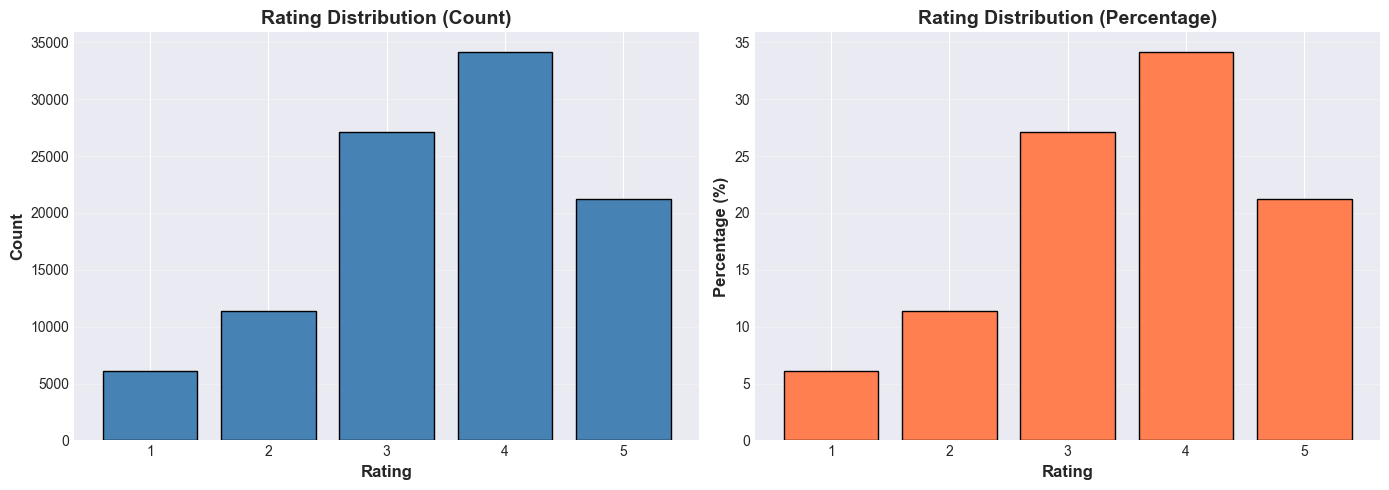


📊 Rating Distribution:
        Count  Percentage
rating                   
1        6110       6.110
2       11370      11.370
3       27145      27.145
4       34174      34.174
5       21201      21.201


In [103]:
# ┌─────────────────────────────────────────┐
# │ Rating Distribution                     │
# └─────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
rating_counts = data['rating'].value_counts().sort_index()
axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Rating', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Rating Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Percentage plot
rating_pct = 100 * rating_counts / len(data)
axes[1].bar(rating_pct.index, rating_pct.values, color='coral', edgecolor='black')
axes[1].set_xlabel('Rating', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Rating Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/01_rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Rating Distribution:")
print(pd.DataFrame({'Count': rating_counts, 'Percentage': rating_pct}))

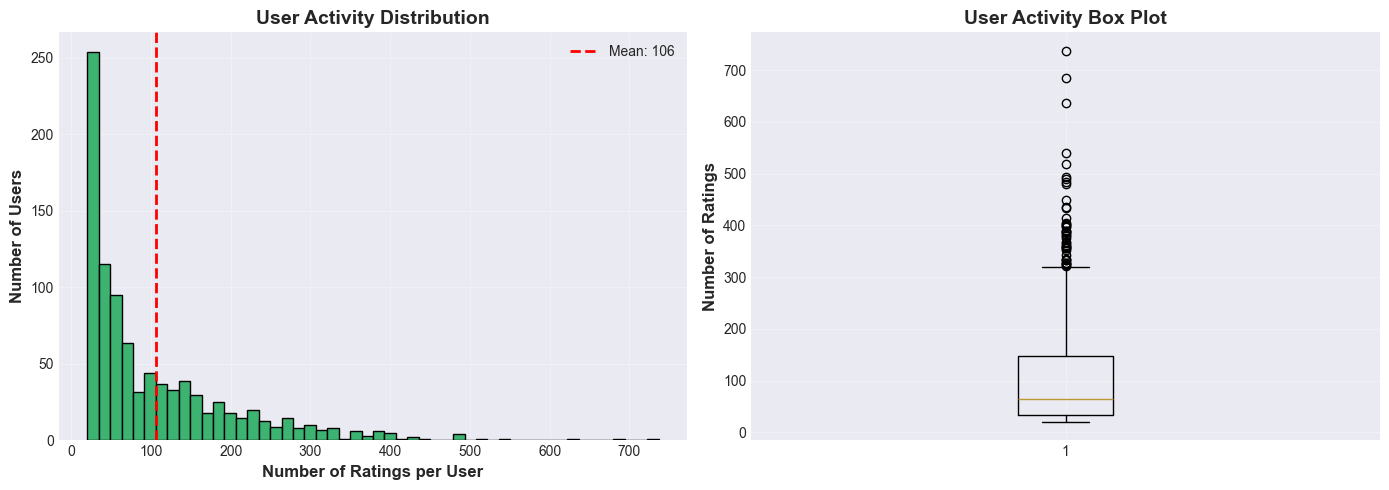


👥 User Activity Statistics:
count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: num_ratings, dtype: float64

Most active user rated 737 movies
Least active user rated 20 movies


In [104]:
# ┌─────────────────────────────────────────┐
# │ User Activity Analysis                  │
# └─────────────────────────────────────────┘

user_activity = data.groupby('user_id').size().reset_index(name='num_ratings')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(user_activity['num_ratings'], bins=50, color='mediumseagreen', edgecolor='black')
axes[0].set_xlabel('Number of Ratings per User', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Users', fontsize=12, fontweight='bold')
axes[0].set_title('User Activity Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(user_activity['num_ratings'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {user_activity["num_ratings"].mean():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(user_activity['num_ratings'], vert=True)
axes[1].set_ylabel('Number of Ratings', fontsize=12, fontweight='bold')
axes[1].set_title('User Activity Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/02_user_activity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n👥 User Activity Statistics:")
print(user_activity['num_ratings'].describe())
print(f"\nMost active user rated {user_activity['num_ratings'].max()} movies")
print(f"Least active user rated {user_activity['num_ratings'].min()} movies")

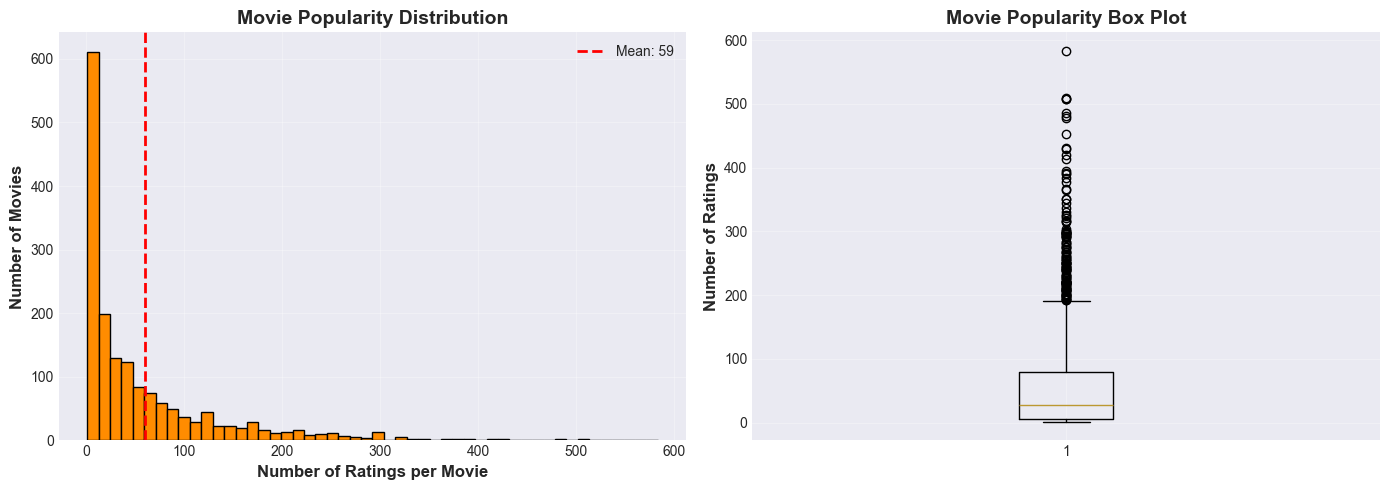


🎬 Movie Popularity Statistics:
count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: num_ratings, dtype: float64

Most rated movie: ['Star Wars (1977)' 583]

Top 10 Most Rated Movies:
                             title  num_ratings  avg_rating
49                Star Wars (1977)          583    4.358491
257                 Contact (1997)          509    3.803536
99                    Fargo (1996)          508    4.155512
180      Return of the Jedi (1983)          507    4.007890
293               Liar Liar (1997)          485    3.156701
285    English Patient, The (1996)          481    3.656965
287                  Scream (1996)          478    3.441423
0                 Toy Story (1995)          452    3.878319
299           Air Force One (1997)          431    3.631090
120  Independence Day (ID4) (1996)          429    3.438228


In [105]:
# ┌─────────────────────────────────────────┐
# │ Movie Popularity Analysis               │
# └─────────────────────────────────────────┘

movie_popularity = data.groupby('item_id').agg({
    'rating': ['count', 'mean'],
    'title': 'first'
}).reset_index()
movie_popularity.columns = ['item_id', 'num_ratings', 'avg_rating', 'title']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(movie_popularity['num_ratings'], bins=50, color='darkorange', edgecolor='black')
axes[0].set_xlabel('Number of Ratings per Movie', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Movies', fontsize=12, fontweight='bold')
axes[0].set_title('Movie Popularity Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(movie_popularity['num_ratings'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {movie_popularity["num_ratings"].mean():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(movie_popularity['num_ratings'], vert=True)
axes[1].set_ylabel('Number of Ratings', fontsize=12, fontweight='bold')
axes[1].set_title('Movie Popularity Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/03_movie_popularity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎬 Movie Popularity Statistics:")
print(movie_popularity['num_ratings'].describe())
print(f"\nMost rated movie: {movie_popularity.nlargest(1, 'num_ratings')[['title', 'num_ratings']].values[0]}")
print(f"\nTop 10 Most Rated Movies:")
print(movie_popularity.nlargest(10, 'num_ratings')[['title', 'num_ratings', 'avg_rating']])

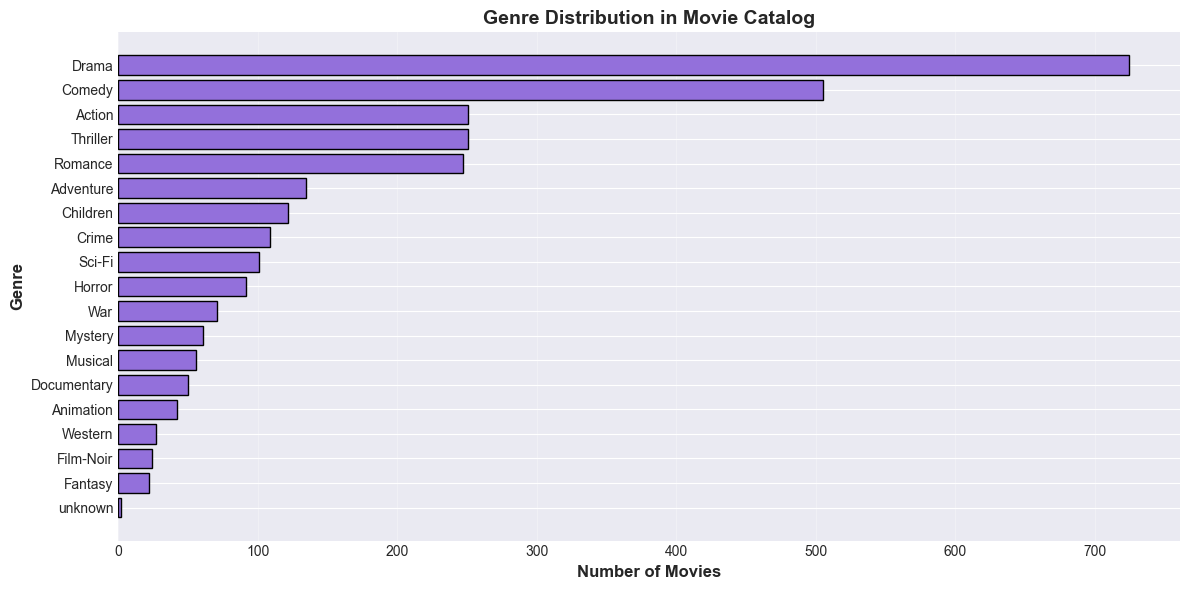


🎭 Genre Distribution:
          Genre  Count
6         Drama    725
2        Comedy    505
3        Action    251
5      Thriller    251
10      Romance    247
4     Adventure    135
1      Children    122
7         Crime    109
8        Sci-Fi    101
11       Horror     92
9           War     71
17      Mystery     61
12      Musical     56
13  Documentary     50
0     Animation     42
14      Western     27
16    Film-Noir     24
15      Fantasy     22
18      unknown      2


In [106]:
# ┌─────────────────────────────────────────┐
# │ Genre Distribution                      │
# └─────────────────────────────────────────┘

# Count genre occurrences
genre_counts = {}
for genres_str in movies['genres']:
    for genre in genres_str.split('|'):
        genre_counts[genre] = genre_counts.get(genre, 0) + 1

genre_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count'])
genre_df = genre_df.sort_values('Count', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(genre_df['Genre'], genre_df['Count'], color='mediumpurple', edgecolor='black')
plt.xlabel('Number of Movies', fontsize=12, fontweight='bold')
plt.ylabel('Genre', fontsize=12, fontweight='bold')
plt.title('Genre Distribution in Movie Catalog', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/visualizations/04_genre_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎭 Genre Distribution:")
print(genre_df)

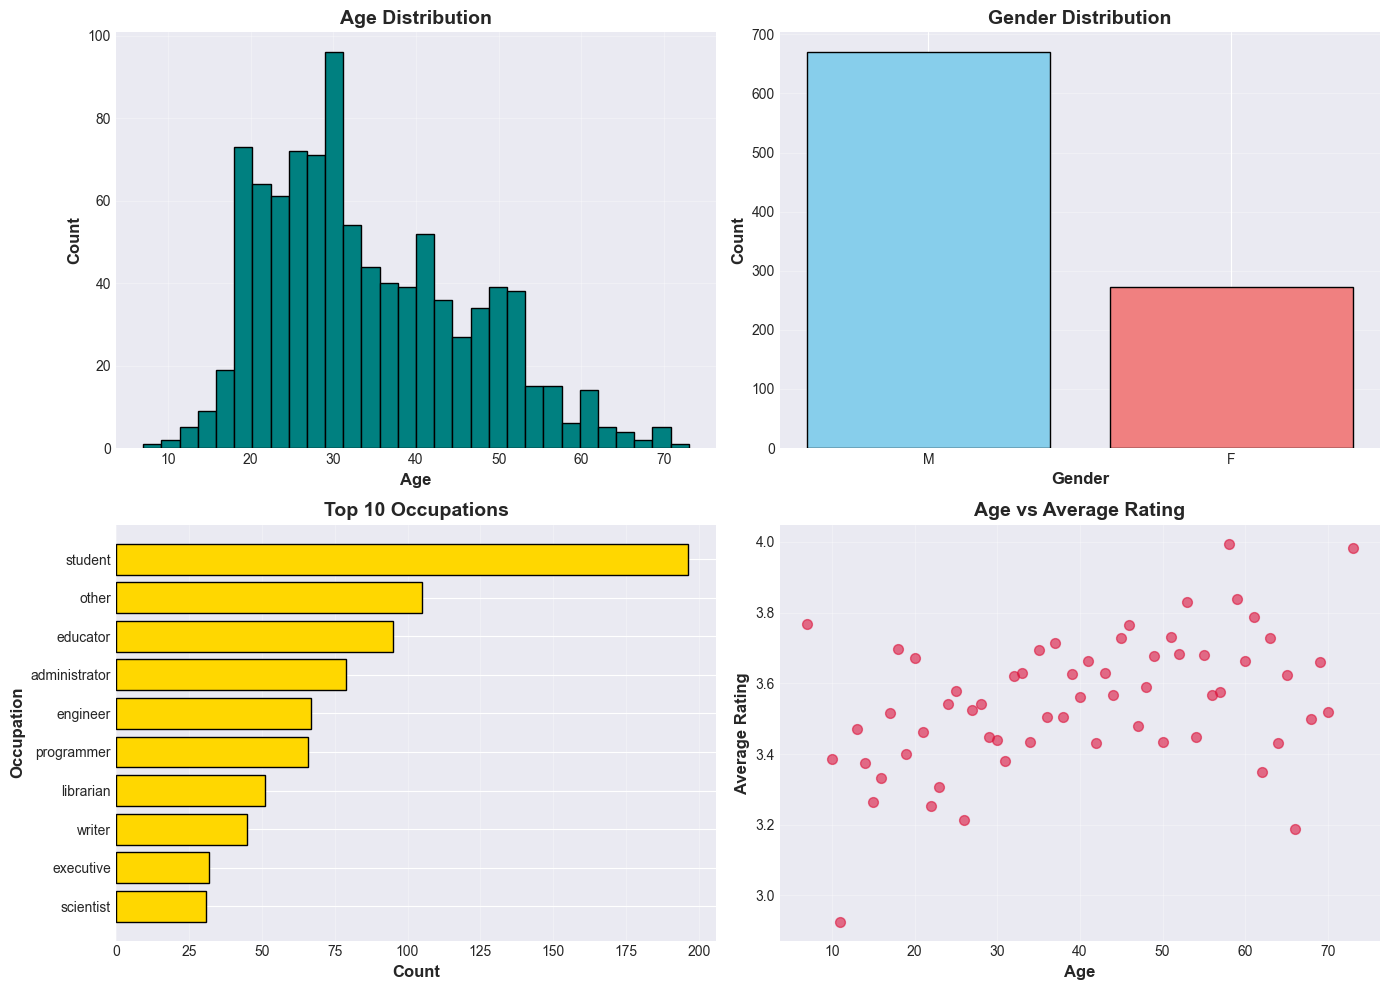


👥 User Demographics Summary:
Age:        Mean=34.1, Median=31
Gender:     {'M': 670, 'F': 273}

Top 5 Occupations:
occupation
student          196
other            105
educator          95
administrator     79
engineer          67
Name: count, dtype: int64


In [107]:
# ┌─────────────────────────────────────────┐
# │ User Demographics                       │
# └─────────────────────────────────────────┘

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(users['age'], bins=30, color='teal', edgecolor='black')
axes[0, 0].set_xlabel('Age', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Gender distribution
gender_counts = users['gender'].value_counts()
axes[0, 1].bar(gender_counts.index, gender_counts.values, color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0, 1].set_xlabel('Gender', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Gender Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Top 10 occupations
occupation_counts = users['occupation'].value_counts().head(10)
axes[1, 0].barh(occupation_counts.index, occupation_counts.values, color='gold', edgecolor='black')
axes[1, 0].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Occupation', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Top 10 Occupations', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Age vs Average Rating
age_rating = data.groupby('age')['rating'].mean().reset_index()
axes[1, 1].scatter(age_rating['age'], age_rating['rating'], color='crimson', s=50, alpha=0.6)
axes[1, 1].set_xlabel('Age', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Average Rating', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Age vs Average Rating', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/05_user_demographics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n👥 User Demographics Summary:")
print(f"Age:        Mean={users['age'].mean():.1f}, Median={users['age'].median():.0f}")
print(f"Gender:     {dict(users['gender'].value_counts())}")
print(f"\nTop 5 Occupations:")
print(users['occupation'].value_counts().head())

## ╔═══════════════════════════════════════════════════════════╗
## ║                  BASELINE MODELS                          ║
## ╚═══════════════════════════════════════════════════════════╝

In [108]:
# ┌─────────────────────────────────────────┐
# │ Train-Test Split                        │
# └─────────────────────────────────────────┘

from sklearn.model_selection import train_test_split

# Use only necessary columns for modeling
model_data = data[['user_id', 'item_id', 'rating']].copy()

# 80-20 split
train_data, test_data = train_test_split(model_data, test_size=0.2, random_state=42)

print("📊 Train-Test Split:")
print(f"   Training samples:   {len(train_data):,}")
print(f"   Test samples:       {len(test_data):,}")
print(f"   Split ratio:        {len(train_data)/len(model_data)*100:.1f}% - {len(test_data)/len(model_data)*100:.1f}%")

📊 Train-Test Split:
   Training samples:   80,000
   Test samples:       20,000
   Split ratio:        80.0% - 20.0%


In [109]:
# ┌─────────────────────────────────────────┐
# │ Evaluation Metrics Functions            │
# └─────────────────────────────────────────┘

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def calculate_rmse(predictions, actuals):
    """
    Calculate Root Mean Squared Error.
    
    Parameters
    ----------
    predictions : array-like
        Predicted ratings
    actuals : array-like
        Actual ratings
    
    Returns
    -------
    float
        RMSE value
    """
    return sqrt(mean_squared_error(actuals, predictions))

def calculate_mae(predictions, actuals):
    """
    Calculate Mean Absolute Error.
    
    Parameters
    ----------
    predictions : array-like
        Predicted ratings
    actuals : array-like
        Actual ratings
    
    Returns
    -------
    float
        MAE value
    """
    return mean_absolute_error(actuals, predictions)

print("✅ Evaluation functions defined")

✅ Evaluation functions defined


In [110]:
# ┌─────────────────────────────────────────┐
# │ Baseline 1: Random Predictor            │
# └─────────────────────────────────────────┘

print("🎲 BASELINE 1: Random Predictor")
print("=" * 50)

# Random predictions between 1 and 5
np.random.seed(42)
random_predictions = np.random.randint(1, 6, size=len(test_data))

random_rmse = calculate_rmse(random_predictions, test_data['rating'].values)
random_mae = calculate_mae(random_predictions, test_data['rating'].values)

print(f"RMSE: {random_rmse:.4f}")
print(f"MAE:  {random_mae:.4f}")

baseline_results = pd.DataFrame({
    'Model': ['Random'],
    'RMSE': [random_rmse],
    'MAE': [random_mae]
})

🎲 BASELINE 1: Random Predictor
RMSE: 1.8882
MAE:  1.5149


In [111]:
# ┌─────────────────────────────────────────┐
# │ Baseline 2: Global Average              │
# └─────────────────────────────────────────┘

print("\n📊 BASELINE 2: Global Average")
print("=" * 50)

# Predict global average rating for all users
global_avg = train_data['rating'].mean()
global_avg_predictions = np.full(len(test_data), global_avg)

global_avg_rmse = calculate_rmse(global_avg_predictions, test_data['rating'].values)
global_avg_mae = calculate_mae(global_avg_predictions, test_data['rating'].values)

print(f"Global Average Rating: {global_avg:.4f}")
print(f"RMSE: {global_avg_rmse:.4f}")
print(f"MAE:  {global_avg_mae:.4f}")

baseline_results = pd.concat([baseline_results, pd.DataFrame({
    'Model': ['Global Average'],
    'RMSE': [global_avg_rmse],
    'MAE': [global_avg_mae]
})], ignore_index=True)


📊 BASELINE 2: Global Average
Global Average Rating: 3.5313
RMSE: 1.1239
MAE:  0.9420


In [112]:
# ┌─────────────────────────────────────────┐
# │ Baseline 3: Popularity-Based            │
# └─────────────────────────────────────────┘

print("\n⭐ BASELINE 3: Popularity-Based")
print("=" * 50)

# Calculate average rating per movie in training set
movie_avg_ratings = train_data.groupby('item_id')['rating'].mean().to_dict()
global_fallback = train_data['rating'].mean()

# Predict using movie average, fallback to global average for unseen movies
popularity_predictions = test_data['item_id'].map(movie_avg_ratings).fillna(global_fallback).values

popularity_rmse = calculate_rmse(popularity_predictions, test_data['rating'].values)
popularity_mae = calculate_mae(popularity_predictions, test_data['rating'].values)

print(f"RMSE: {popularity_rmse:.4f}")
print(f"MAE:  {popularity_mae:.4f}")

baseline_results = pd.concat([baseline_results, pd.DataFrame({
    'Model': ['Popularity-Based'],
    'RMSE': [popularity_rmse],
    'MAE': [popularity_mae]
})], ignore_index=True)


⭐ BASELINE 3: Popularity-Based
RMSE: 1.0210
MAE:  0.8123


In [113]:
# ┌─────────────────────────────────────────┐
# │ Baseline Results Summary                │
# └─────────────────────────────────────────┘

print("\n📊 BASELINE MODELS COMPARISON")
print("=" * 50)
print(baseline_results.to_string(index=False))

# Save results
baseline_results.to_csv('../results/baseline_results.csv', index=False)
print("\n💾 Results saved to: baseline_results.csv")


📊 BASELINE MODELS COMPARISON
           Model     RMSE      MAE
          Random 1.888160 1.514850
  Global Average 1.123860 0.941955
Popularity-Based 1.020964 0.812273

💾 Results saved to: baseline_results.csv


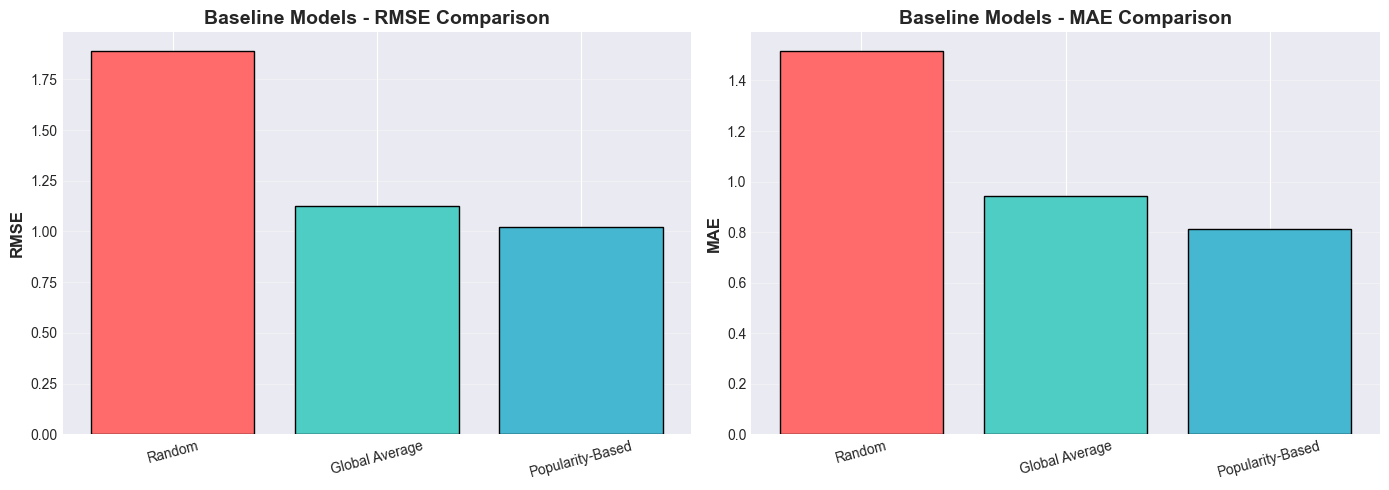

In [114]:
# ┌─────────────────────────────────────────┐
# │ Visualize Baseline Performance          │
# └─────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
axes[0].bar(baseline_results['Model'], baseline_results['RMSE'], 
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Baseline Models - RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# MAE comparison
axes[1].bar(baseline_results['Model'], baseline_results['MAE'],
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Baseline Models - MAE Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('../results/visualizations/06_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## ╔═══════════════════════════════════════════════════════════╗
## ║                  PHASE 1 SUMMARY                          ║
## ╚═══════════════════════════════════════════════════════════╝

In [115]:
print("="*60)
print("                 PHASE 1 COMPLETE ✅")
print("="*60)
print("\n📦 DELIVERABLES:")
print("   ✅ MovieLens 100K dataset downloaded and extracted")
print("   ✅ Merged dataset created (movielens_100k_merged.csv)")
print("   ✅ Exploratory Data Analysis completed")
print("   ✅ 6 visualizations saved (01-06.png)")
print("   ✅ 3 baseline models evaluated")
print("   ✅ Baseline results saved (baseline_results.csv)")

print("\n📊 KEY FINDINGS:")
print(f"   • Dataset: {len(data):,} ratings, {n_users} users, {n_items} movies")
print(f"   • Sparsity: {sparsity:.2f}% (Density: {100-sparsity:.2f}%)")
print(f"   • Best Baseline: {baseline_results.loc[baseline_results['RMSE'].idxmin(), 'Model']}")
print(f"   • Best RMSE: {baseline_results['RMSE'].min():.4f}")

print("\n🎯 NEXT STEPS:")
print("   → Phase 2: Implement Collaborative Filtering (User-Based, Item-Based)")
print("   → Goal: Beat baseline RMSE of {:.4f}".format(baseline_results['RMSE'].min()))
print("\n" + "="*60)

                 PHASE 1 COMPLETE ✅

📦 DELIVERABLES:
   ✅ MovieLens 100K dataset downloaded and extracted
   ✅ Merged dataset created (movielens_100k_merged.csv)
   ✅ Exploratory Data Analysis completed
   ✅ 6 visualizations saved (01-06.png)
   ✅ 3 baseline models evaluated
   ✅ Baseline results saved (baseline_results.csv)

📊 KEY FINDINGS:
   • Dataset: 100,000 ratings, 943 users, 1682 movies
   • Sparsity: 93.70% (Density: 6.30%)
   • Best Baseline: Popularity-Based
   • Best RMSE: 1.0210

🎯 NEXT STEPS:
   → Phase 2: Implement Collaborative Filtering (User-Based, Item-Based)
   → Goal: Beat baseline RMSE of 1.0210

